In [1]:
import os
import re
import sys
import numpy as np
import periodictable as pt
import matplotlib.pyplot as plt
from PIL import Image

#add the parent folder to sys path so we can import from the notebook subfolder
sys.path.insert(0,'..')
import xfmreadout.clustering as clustering

BASEDIR = "/home/lachlan/CODEBASE/ReadoutXFM/"
TIFDIR = "data/processed_maps/zoe_25um/S1"
EXT='.tiff'
#INITELEMENTS=['sum','Compton']
IGNORE_ELEMENTS=['sum','Compton', 'Mo']

TRUE_ELEMENTS = []

for ptelement in pt.elements:
    TRUE_ELEMENTS.append(ptelement.symbol)



/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_elements(files):

    elements=[]
    keepfiles=[]    

    for fname in files:

        try:
            found=re.search('\-(\w+)\.', fname).group(1)
        except AttributeError:
            print(f"WARNING: no element found in {fname}")
            found=''
        finally:
            if found in IGNORE_ELEMENTS:
                pass
            elif found in TRUE_ELEMENTS:
                elements.append(found)
                keepfiles.append(fname)
            else:
                print(f"WARNING: Unexpected element {found} not used")

    files = keepfiles
    if len(elements) == len(files):
        zipped = zip(elements, files)    
        zipped_sorted = sorted(zipped)

        elements = [elements for elements, files  in zipped_sorted]
        files = [files for elements, files in zipped_sorted]

    else:
        raise ValueError("mismatch between elements and files")
    

    
    """
    move sum, compton etc at start - does not change files, only elements
    
    for iidx, ivalue in enumerate(INITELEMENTS):
        for idx, value in enumerate(elements):
            if ivalue ==  value:
                elements.remove(ivalue)
        elements.insert(iidx,ivalue)            
    """

    return elements, files

In [6]:
"""
for f in files:
    im = Image.open(f)
    img = np.array(im)
"""
BASEFACTOR=100000
MODIFY_LIST = ['Na', 'Mg', 'Al', 'Si']
MODIFY_FACTORS = [ 100, 1, 1, 1 ]

wdir = os.path.join(BASEDIR, TIFDIR)

files = [f for f in os.listdir(wdir) if f.endswith('.tiff')]

elements, files = get_elements(files)

filepaths = [os.path.join(wdir, file) for file in files ] 

#get file dimensions:

im = Image.open(os.path.join(wdir, filepaths[0]))
im = Image.open(filepaths[0])
img = np.array(im)

dims = img.shape

maps=np.zeros((len(elements), dims[0], dims[1]), dtype=np.float32)

print(len(elements))
print(len(filepaths))

i=0
for f in filepaths:
    im = Image.open(f)
    img = np.array(im)
    #replace all negative values with 0
    img = np.where(img<0, 0, img)

    factor=BASEFACTOR
    for idx, snames in enumerate(MODIFY_LIST):
        if elements[i] in snames:
            factor=BASEFACTOR*MODIFY_FACTORS[idx]

    maps[i,:,:]=img/factor
    i+=1
    

data=maps.reshape(maps.shape[0],-1)

data=np.swapaxes(data,0,1)

print(maps.shape, data.shape)

20
20
(20, 580, 1150) (667000, 20)


['Al', 'As', 'Ca', 'Cl', 'Cr', 'Cu', 'Fe', 'K', 'Mg', 'Mn', 'Na', 'Ni', 'Rb', 'S', 'Si', 'Sr', 'Ti', 'V', 'Zn', 'Zr']
Mg
0.0 0.09601512551307678 1.9778290510177612


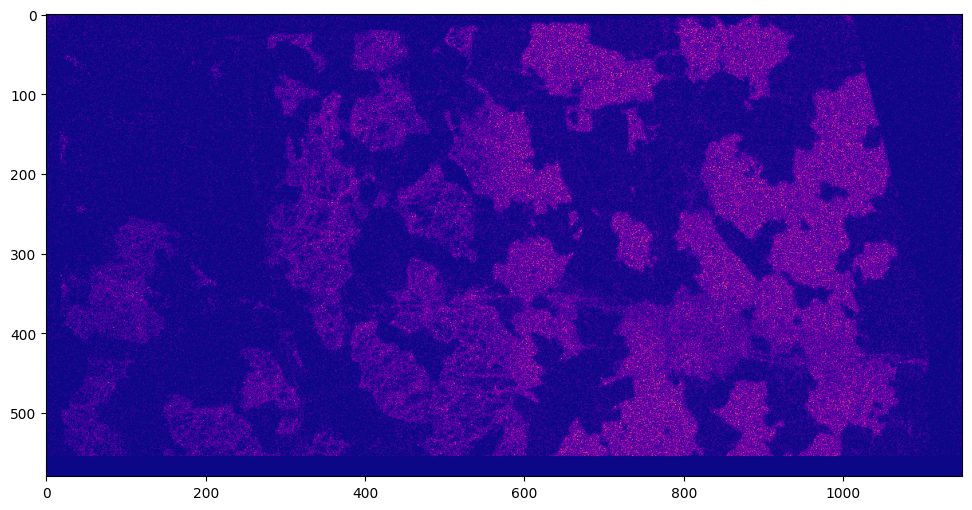

In [4]:
IDX=8

img = maps[IDX,:,:]

print(elements)
print(elements[IDX])
print(np.quantile(img, 0.1), np.quantile(img, 0.5), np.quantile(img, 0.9))

fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)

display = ax.imshow(img, cmap='plasma')

plt.show()

In [5]:
"""
calculate clusters
"""

EMBED_DIR=os.path.join(wdir,"embeddings")

NPX=dims[0]*dims[1]

N_CLUSTERS=6

NCHAN=maps.shape[0]

FORCE=False

if FORCE:
    categories, classavg, embedding, clusttimes = clustering.calculate(data, NPX, N_CLUSTERS, NCHAN )
else:
    categories = np.load(os.path.join(EMBED_DIR,"categories.npy"))
    classavg = np.load(os.path.join(EMBED_DIR,"classavg.npy"))
    embedding = np.load(os.path.join(EMBED_DIR,"embedding.npy"))
    clusttimes = np.load(os.path.join(EMBED_DIR,"clusttimes.npy"))

In [6]:
np.save(os.path.join(EMBED_DIR,"categories.npy"),categories)

np.save(os.path.join(EMBED_DIR,"classavg.npy"),classavg)

np.save(os.path.join(EMBED_DIR,"embedding.npy"),embedding)

np.save(os.path.join(EMBED_DIR,"clusttimes.npy"),clusttimes)


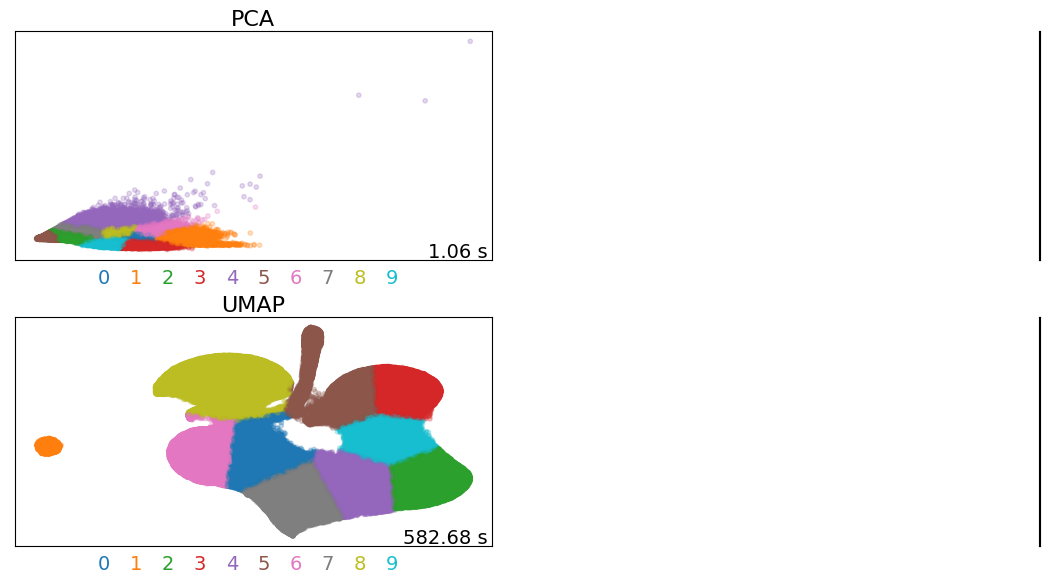

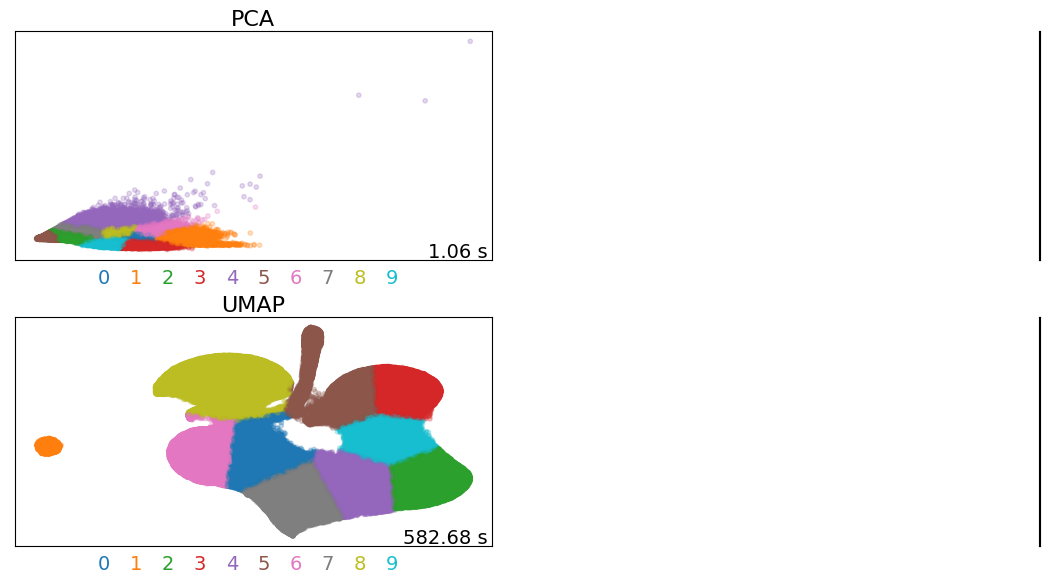

In [6]:
clustering.clustplt(embedding, categories, maps.shape[0], clusttimes)

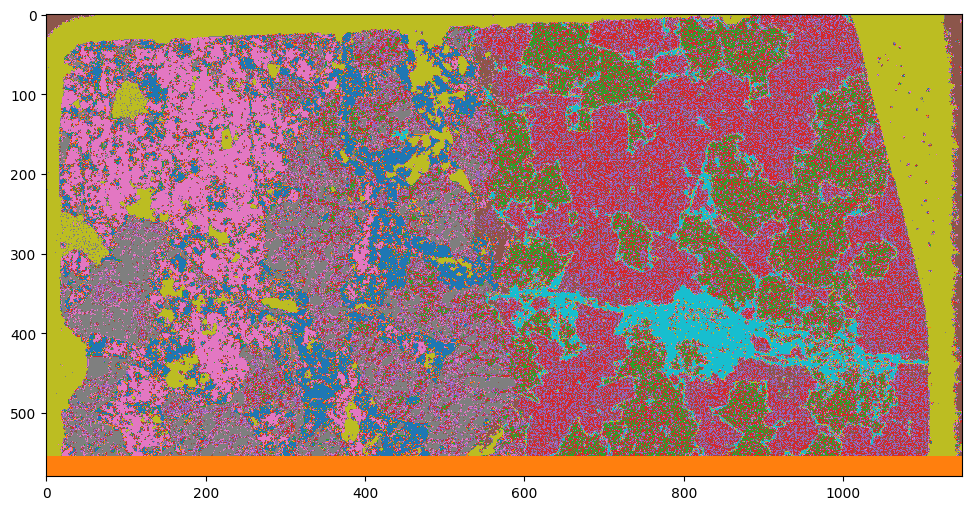

In [8]:
"""
image of categories
"""

from matplotlib import cm

KCMAPS=["tab10","tab10"]    #colourmaps for kmeans

categories.shape

REDUCER=1


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ncats=np.max(categories)+1

axcm=cm.get_cmap(KCMAPS[REDUCER], ncats)

cmap=axcm(range(ncats))

#reshape the category list back to the map dimensions using xdim
#WARNING: fails using SHORTRUN unless ends at end of row - fix this later

catmap=np.reshape(categories[REDUCER], [dims[0],-1])

#show this category image
ax.imshow(catmap, cmap=KCMAPS[REDUCER])


#fig.savefig(os.path.join(EMBED_DIR,"cluster_map.png"), dpi=200)

ValueError: x and y must be the same size

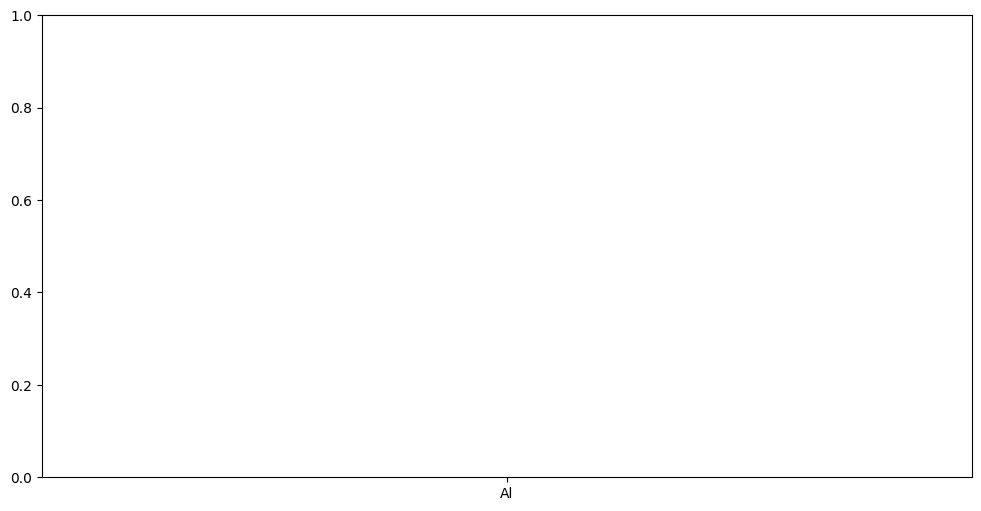

In [9]:
"""
average-by-element-by-category
"""

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

ncats=np.max(categories)+1

elids=range(len(elements))

#ax.set_yscale('log')

for i in range(ncats-1):
    ax.scatter(elements, classavg[0,i,:], linewidth=1)


fig.show()

In [7]:
print(classavg[0,i,:].shape)
print(len(elements))


IndexError: index 20 is out of bounds for axis 1 with size 10

(2, 667000)
(667000, 20)


/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


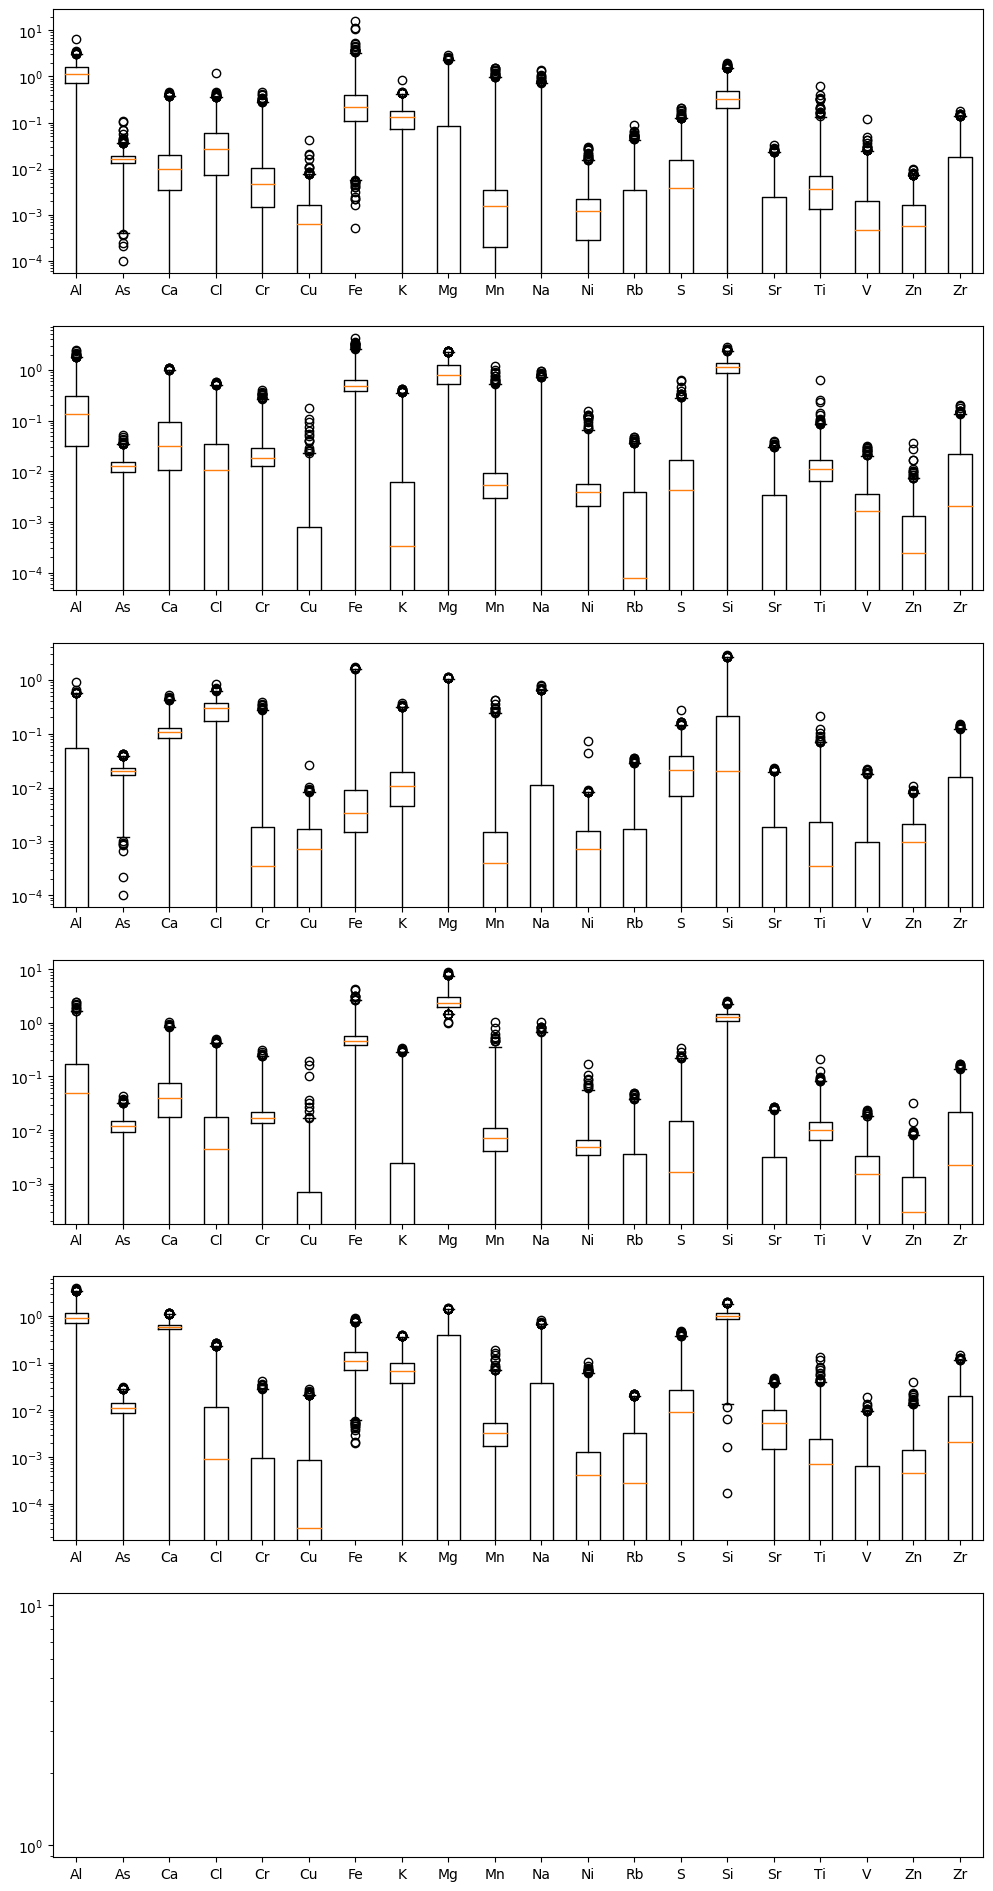

In [32]:
"""
category:element boxplots
"""

ncats=np.max(categories)+1
catlist=range(ncats)

print(categories.shape)
print(data.shape)

boxdata=np.zeros((ncats,len(elements),categories.shape[1]))


#fig = plt.figure(figsize =(12, 6))

fig, (ax) = plt.subplots(ncats, 1, figsize=(12, 24))

#ax = fig.add_subplot(111)

for cat_idx in catlist:
    assigned=np.where(categories[REDUCER] == cat_idx, True, False)

    selected=[]

    for el_idx, ename in enumerate(elements):
        boxdata[cat_idx,el_idx,:]=data[:,el_idx]*assigned
        selected.append(data[assigned,el_idx])
      
        # Creating plot

    ax[cat_idx].set_yscale('log')

    ax[cat_idx].boxplot(selected, labels=elements, whis=[0.01,99.99])

fig.show()

In [6]:
#https://towardsdatascience.com/19-examples-of-merging-plots-to-maximize-your-clustering-scatter-plot-87e8f1bb5fd2

import pandas as pd
import seaborn as sns


color_dict = {0:'#F65E5D',
              1:'#3AB4F2',
              2:'#FFBC46',
              3:'#FF0000',
              4:'#00FF00',
              5:'#0000FF'}

df= pd.DataFrame(embedding[1,:], columns=["x","y"])

df["cat"]=categories[1,:]

df

df = df[df.x > -7.5]

/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


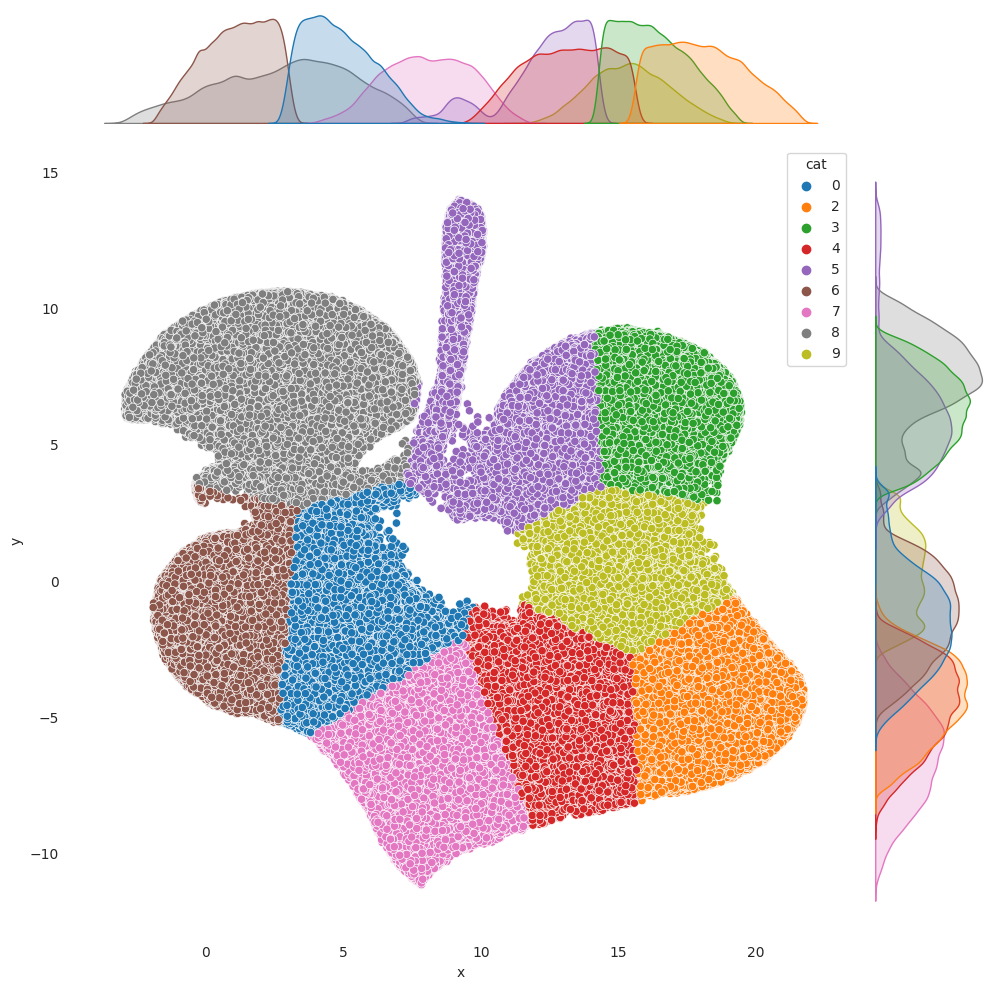

In [7]:
### scatter plot with marginal axes
sns.set_style('white')
sns.jointplot(x=df.x, y=df.y,
              hue=df.cat, palette=sns.color_palette(),
              lw=0,
              height=10, ratio=6
             )

#xlim=[-3,3], ylim=[-3,3],

ax = sns.despine(ax=None, left=True, bottom=True)
#plt.savefig('j_scatter_tr.png', transparent=True)
plt.show()

/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1826: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=self.x, y=self.y, **kwargs)
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1877: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/home/lachlan/.pyenv/versions/3.7.13/envs/venv_readoutxfm/lib/python3.7/site-packages/seaborn/axisgrid.py:1883: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


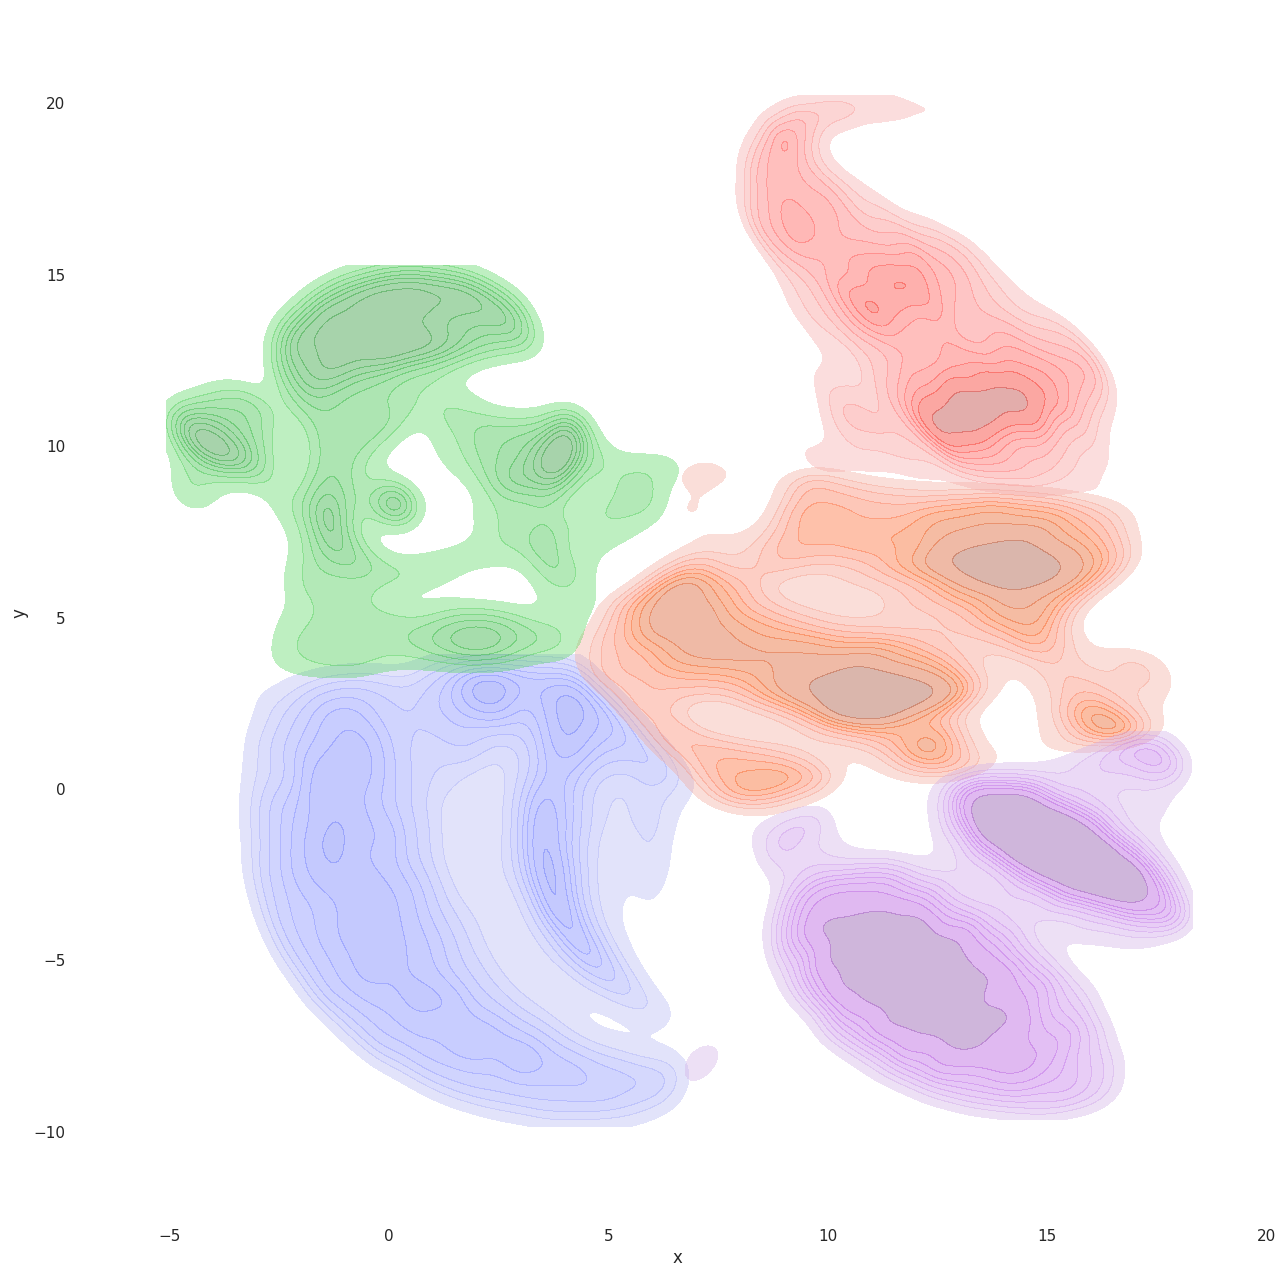

In [62]:
### kde plot filled with colors with transparent background
sns.set_style('white')
ax = sns.jointplot(x=df.x, y=df.y,
              cut = 0, hue=df.cat,
              palette=sns.color_palette("dark"),
              kind='kde', fill=True,
              height=15, ratio=6,
              joint_kws = dict(alpha=0.4),
              marginal_kws=dict(fill=True),
              legend=False)
ax.ax_marg_x.remove()
ax.ax_marg_y.remove()
ax = sns.despine(ax=None, left=True, bottom=True)
#plt.savefig('kde_tr_fill.png', transparent=True)
plt.show()

In [15]:
from sklearn.cluster import DBSCAN
from sklearn import decomposition
import hdbscan
import umap.umap_ as umap

n_clusters=10
n_channels=data.shape[1]
totalpx=data.shape[0]

reducers = [
    (decomposition.PCA, {}),
#    (decomposition.IncrementalPCA, {"batch_size": 10000}),
#    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3, "low_memory": True, "verbose": True}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3, "low_memory": True}),
]

nred=len(reducers)

def dodbscan(embedding, npx):
    """
    performs kmeans on embedding matrices to cluster 2D matrices from reducers 

    args:       set of 2D embedding matrices (shape [nreducers,x,y]), number of pixels in map
    returns:    category-by-pixel matrix, shape [nreducers,chan]
    """
    #initialise kwargs
    dbscan = hdbscan.HDBSCAN(
        min_cluster_size=1000,
        min_samples=500,
        cluster_selection_epsilon=0.5
    )
    #dbscan = DBSCAN(
    #    eps=0.5,
    #    min_samples=totalpx/50
    #)

    categories=np.zeros((nred,npx),dtype=np.uint16)
    for i in np.arange(0,nred):
        redname=repr(reducers[i][0]()).split("(")[0]
        embed = embedding[i,:,:]

        print(f'DBSCAN clustering {i+1} of {nred}, reducer {redname} across {npx} elements')

        #DO:
        dbscan.fit(embed)
        categories[i]=dbscan.labels_

    return categories



categoriesdb = dodbscan(embedding, totalpx)

#produce and save cluster averages

#   initialise averages
classavgdb=np.zeros([len(reducers),n_clusters, n_channels])

#   cycle through reducers
for i in range(len(reducers)):
    classavgdb[i]=clustering.sumclusters(data, categoriesdb[i], n_clusters, n_channels)    









DBSCAN clustering 1 of 2, reducer PCA across 667000 elements
DBSCAN clustering 2 of 2, reducer UMAP across 667000 elements


../xfmreadout/clustering.py:126: RuntimeWarning: invalid value encountered in true_divide
  specsum[i,:]=(np.sum(datcat,axis=0))/pxincat


In [23]:
categoriesdb[1,:]

array([1, 1, 1, ..., 0, 0, 0], dtype=uint16)